# IPCC Tier 1 method for avoided emission estimation after rewetting degraded peatland

In this example notebook the impact on the avoided emission will be calculated. 
Based on the proposal of Daniel Zimmer the following strategy was used to identify degraded peatland:

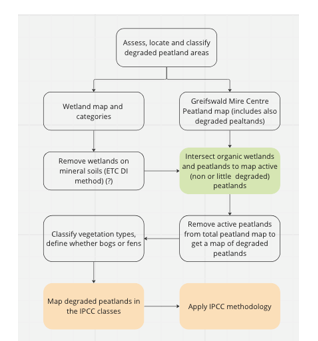

The actual avoided emission is calculated by applying the corresponding IPCC tables: Hiraishi T. et al, IPCC, 2013

#### The focus is for the moment only on CO2 related emissions!!!



In [1]:
### Import the required packages
import os
from loguru import logger as log
from pathlib import Path
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import datetime
import shapely
from shapely.geometry.multipolygon import MultiPolygon
import sys



sys.path.append(os.path.join(Path(os.getcwd()).parent, 'src'))
from SOC_scenarios.utils.spark import get_spark_sql
from SOC_scenarios.utils.soc_helper_functions import (
    define_processing_grid,
    add_metadata_raster)
from Peatland.rewetting_functions import (
    get_degraded_peatland,
    estimate_avoided_emissions,
    stats_region)

### Define input folders and reference data

In [2]:
log.info('*' * 50)

from constants import (
    dir_signature,
    CLC_IPCC_mapping_refinement,
    path_IPCC_climate_resampled)

# below the id for peatland
# occurance is defined based
#  on the peatland map
peatland_id = 104

# Define locations of raster based datasets
#!!!!!! Should be changed once know central location for data access
DATASETS = {
    'LUC': os.path.join(dir_signature, 'input_data', 'general',
                        'CLCACC', 'CLC2018ACC_V2018_20.tif'),
    'EXT_WETL': os.path.join(dir_signature, 'etc', 'lulucf',
                             'input_data', 'Ext_wetland',
                             'ext_wetland_2018_v2021_nw.tif'),
    'CLIMATE_ZONES': path_IPCC_climate_resampled,
    'Peatland_map': os.path.join(dir_signature, 'etc', 'lulucf',
                                 'input_data', 'Peatland',
                                 'PeatlandMap_EEA39_compress.tif'),

}

# Define locations of vector based datasets for spatial aggregation

VECTORS = {
    'NUTS': os.path.join(dir_signature, 'etc',
                         'lulucf', 'AOI',
                         'NUTS_RG_20M_2021_3035.shp')
}

# Define locations of required LUT

TABLES = {
    'DRAINED_EMISS': os.path.join(os.getcwd(), 'data', 'Peatland_LUT',
                                  'IPCC_emissions_drained_peat.csv'),
    'REWETTED_EMISS': os.path.join(os.getcwd(), 'data', 'Peatland_LUT',
                                   'IPCC_emissions_rewetted_peat.csv')
}

overwrite = False

#!!!!!! Should be changed once know central location for data output
Basefolder_output = os.path.join(os.getcwd(), 'out') 
os.makedirs(Basefolder_output, exist_ok=True)

# Define if the script should be parallellized or processed locally
# First deal with the spark stuff
run_local = True
if not run_local:
    sql = get_spark_sql(local=run_local)
else:
    sql = None

# store all processing settings in dictionary
settings = {'DATASETS': DATASETS,
            'TABLES': TABLES,
            'VECTORS': VECTORS,
            'BASEFOLDER': Basefolder_output,
            'peat_id': peatland_id,
            'scale_factor': 0.01,
            'overwrite': overwrite,
            'CLC_mapping_LULUCF': CLC_IPCC_mapping_refinement,
            'Kernel': 1024}

2023-05-02 13:09:58.130 | INFO     | __main__:<module>:1 - **************************************************


### Define the processing grid to allow parallellisation of the process

In [3]:
keys_dataset = list(settings.get('DATASETS').keys())
dir_ref = settings.get('DATASETS').get(keys_dataset[0])
xdim, ydim = rasterio.open(dir_ref).shape
df_grid_proc = define_processing_grid(settings,
                                      xdim, ydim)
log.info((f'A total of {df_grid_proc.shape[0]} windows have'
          ' been defined in this patch ...'))

2023-05-02 13:09:58.213 | INFO     | __main__:<module>:6 - A total of 2772 windows have been defined in this patch ...


### PART1: Determine degraded peatland


In [4]:
# Check if can access the file in the first place,
# otherwise regeneration will be needed

outfolder_degr_peat = os.path.join(settings.get('BASEFOLDER'),
                                   'raster')
os.makedirs(outfolder_degr_peat, exist_ok=True)

outname_degr_peat = 'Degraded_peatland.tif'



if not os.access(os.path.join(outfolder_degr_peat, outname_degr_peat), os.R_OK) \
            and os.path.exists(os.path.join(outfolder_degr_peat, outname_degr_peat)):  # NOQA
        log.warning('Cannot open degradation file --> so do processing again!')
        os.unlink(os.path.join(outfolder_degr_peat, outname_degr_peat))

if not os.path.exists(os.path.join(outfolder_degr_peat, outname_degr_peat)) or settings.get('overwrite'):

    if os.path.exists(os.path.join(outfolder_degr_peat, outname_degr_peat)):
        os.unlink(os.path.join(outfolder_degr_peat, outname_degr_peat))
    get_degraded_peatland(settings, df_grid_proc, outfolder_degr_peat,
                          outname_degr_peat, sql=sql)

    log.success('Degraded peatland mapping finished')

# add patch of degraded peatland to settings
DATASETS = settings.get('DATASETS')
DATASETS.update({'DEGRADED_PEAT': os.path.join(outfolder_degr_peat,
                                               outname_degr_peat)})
settings.update({'DATASETS': DATASETS})

### PART2: Determine avoided emissions degraded peatland

IPCC EMISSION FACTORS ARE USED IN CASE OF MULTIPLE EMISSIONS FACTORS DEPENDING ON DRAINAGE OR NUTRIENT STATUS, THE MEAN VALUE WAS TAKEN

FOR THE REWETTING EMISSIONS ALSO THE MEAN VALULE BETWEEN NUTRIENT RICH AND POOR WAS TAKEN

Pixel-based calculation for avoided emissions on degraded peatland.

The following table formed the stating point for assessing avoided emissions (only CO2 emissions considered):

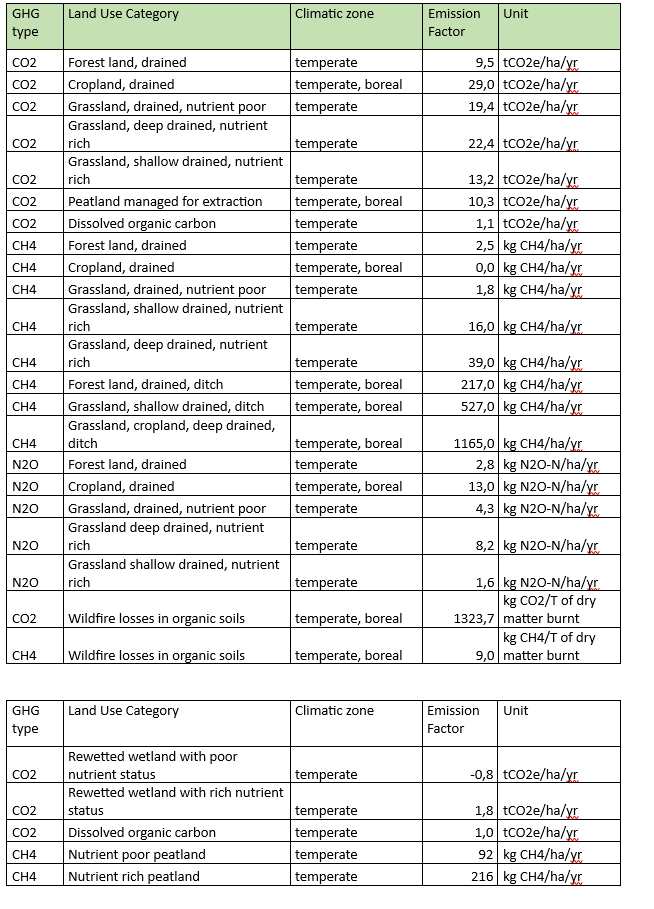


In [5]:
log.info(f'Drained emissions LUT: \n {pd.read_csv(settings.get("TABLES").get("DRAINED_EMISS"), sep=";")}')
log.info(f'Rewetted emissions LUT: \n {pd.read_csv(settings.get("TABLES").get("DRAINED_EMISS"), sep=";")}')

2023-05-02 13:09:58.251 | INFO     | __main__:<module>:1 - Drained emissions LUT: 
     IPCC_climate_id     IPCC_climate_name    IPCC_LU Emission (tCO2e/ha/yr)
0                 1  Warm Temperate Moist   Cropland                  29.00
1                 2    Warm Temperate Dry   Cropland                  29.00
2                 3  Cool Temperate Moist   Cropland                  29.00
3                 4    Cool Temperate Dry   Cropland                  29.00
4                 5           Polar Moist   Cropland                   None
5                 6             Polar Dry   Cropland                   None
6                 7          Boreal Moist   Cropland                  29.00
7                 8            Boreal Dry   Cropland                  29.00
8                 9      Tropical Montane   Cropland                   None
9                10          Tropical Wet   Cropland                   None
10               11        Tropical Moist   Cropland                   None
11  

In [6]:
log.info('Start mapping pixel-based avoided emissions')

outfolder_emis = os.path.join(settings.get('BASEFOLDER'),
                              'raster')
outname_emis = 'Avoided_emissions_yrl.tiff'

if not os.access(os.path.join(outfolder_emis, outname_emis), os.R_OK) \
        and os.path.exists(os.path.join(outfolder_emis, outname_emis)):  # NOQA
    log.warning('Cannot open degradation file --> so do processing again!')
    os.unlink(os.path.join(outfolder_emis, outname_emis))

if not os.path.exists(os.path.join(outfolder_emis, outname_emis)) or settings.get('overwrite'):

    if os.path.exists(os.path.join(outfolder_emis, outname_emis)):
        os.unlink(os.path.join(outfolder_emis, outname_emis))

    estimate_avoided_emissions(settings, df_grid_proc,
                               outfolder_emis, outname_emis,
                               sql)

2023-05-02 13:09:58.268 | INFO     | __main__:<module>:1 - Start mapping pixel-based avoided emissions


### PART3: SPATIAL AGGREGATE AVOIDED EMISSIONS

In [7]:
# Summarize the potential for rewetting
# for different NUTS regions

# Define the output folder
outfolder_vector_stats = os.path.join(settings.get('BASEFOLDER'),
                                      'vector')
outname_vectors_stats = 'NUTS_avoided_emissions_yrly.geojson'
os.makedirs(outfolder_vector_stats, exist_ok=True)

if not os.access(os.path.join(outfolder_vector_stats, outname_vectors_stats), os.R_OK) \
    and os.path.exists(os.path.join(outfolder_vector_stats, outname_vectors_stats)):  # NOQA
    log.warning(
        'Cannot open aggregated avoided emissions --> do processing again')
    os.unlink(os.path.join(outfolder_vector_stats, outname_vectors_stats))

if not os.path.exists(os.path.join(outfolder_vector_stats, outname_vectors_stats)) or settings.get('overwrite'):
    if os.path.exists(os.path.join(outfolder_vector_stats, outname_vectors_stats)):
        os.unlink(os.path.join(outfolder_vector_stats, outname_vectors_stats))

    stats_region(settings.get('VECTORS').get('NUTS'),
                 os.path.join(outfolder_emis, outname_emis),
                 os.path.join(outfolder_degr_peat, outname_degr_peat),
                 os.path.join(outfolder_vector_stats,
                              outname_vectors_stats),
                 settings, sql=sql)